In [125]:
#importing the libraries
import json
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model

In [126]:
#importing the dataset
with open('content.json') as content:
  data1 = json.load(content)

In [127]:
#getting all the data to lists
tags = []
inputs = []
responses={}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [128]:
#converting to dataframe
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [129]:
data

,inputs,tags
0,hello,greeting
1,hi there,greeting
2,nice to meet you,greeting
3,hi,greeting
4,hey there,greeting
5,hey,greeting
6,hi there,greeting
7,"hi, nice to meet you",greeting
8,hello there,greeting
9,anyone there ?,greeting


In [130]:
data = data.sample(frac=1)

In [131]:
#removing punctuations
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
0,hello,greeting
56,iam not feeling well,tiggerwords
8,hello there,greeting
30,are you fine,howami
36,who are you,whoareyou
24,i will talk to you later,goodbye
10,hello bot,greeting
41,your name,whoareyou
17,adios,goodbye
58,i think i am unwell,tiggerwords


In [132]:
#tokenize the data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])
#apply padding
x_train = pad_sequences(train)

#encoding the outputs
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [133]:
input_shape = x_train.shape[1]
print(input_shape)

7


In [134]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  68
output length:  6


In [135]:
#creating the model

i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(20,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model  = Model(i,x)

In [136]:
#compiling the model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [137]:
#training the model
train = model.fit(x_train,y_train,epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 5ms/step - loss: 1.7930 - accuracy: 0.1167
Epoch 2/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7899 - accuracy: 0.1667
Epoch 3/100
2/2 [==============================] - 0s 6ms/step - loss: 1.7873 - accuracy: 0.2000
Epoch 4/100
2/2 [==============================] - 0s 8ms/step - loss: 1.7850 - accuracy: 0.2333
Epoch 5/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7823 - accuracy: 0.2667
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7792 - accuracy: 0.2667
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7765 - accuracy: 0.2667
Epoch 8/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7735 - accuracy: 0.2667
Epoch 9/100
2/2 [==============================] - 0s 6ms/step - loss: 1.7698 - accuracy: 0.2667
Epoch 10/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7664 - accuracy: 0.2667
Epoch 11/100
2/2 [===========

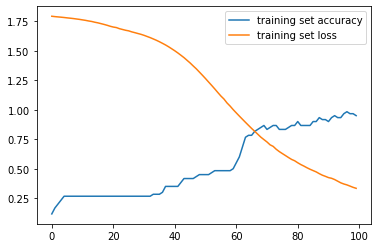

In [141]:
#plotting model accuracy
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

In [142]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [139]:
def symptom_extractor():
    print("tell me your symptoms")

In [140]:
while True:
  texts_p = []
  predition_input = input('You : ')
  #removing punctuation and converting to lowercase
  predition_input_1 = [letters.lower() for letters in  predition_input if letters not in string.punctuation]
  predition_input_1 = ''.join(predition_input_1)
  texts_p.append(predition_input_1)
  #tokenizing and padding
  predition_input_1 = tokenizer.texts_to_sequences(texts_p)
  predition_input_1 = np.array(predition_input_1).reshape(-1)
  predition_input_1 = pad_sequences([predition_input_1],input_shape)
  #getting output from model
  output = model.predict(predition_input_1)
  output = output.argmax()
  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("You : ", predition_input)
  print("Going Merry : ",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break
  elif response_tag == "tiggerwords":
    symptom_extractor()

You :  hello
Going Merry :  welcome aboard, how may I help you ?
You :  who; are youj
Going Merry :  My name is Sunbot and I am here to answer your questions regarding our organization. go ahead and shoot
You :  i am not wekk'
Going Merry :  Tell me about your symptoms
tell me your symptoms
You :  how are you
Going Merry :  Yeah , am fine
You :  i am sick
Going Merry :  Tell me about your symptoms
tell me your symptoms
You :  i am fine
Going Merry :  Tell me about your symptoms
tell me your symptoms
You :  i am not fine
Going Merry :  Tell me about your symptoms
tell me your symptoms
You :  clear
Going Merry :  Ha , Glad you showed up. How are you ?
You :  eixt
Going Merry :  ahoy!!
You :  exit
Going Merry :  Hey yo, do you need help ?
You :  bye
Going Merry :  we'll meet soon
